In [18]:
import numpy as np # Successfully installed numpy-1.23.5
import pandas as pd # Successfully installed pandas-1.3.5
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch.nn as nn
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split, Subset
import torch
import sys
import time
import hydra
from omegaconf import DictConfig, OmegaConf
import wandb
import json
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
sys.path.append(os.path.abspath(".."))
from models.models import GATWithJK
from preprocessing import graph_creation
from training_utils import PyTorchTrainer, PyTorchDistillationTrainer, DistillationTrainer

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
teacher_model = GATWithJK(in_channels=10, hidden_channels=32, out_channels=1, num_layers=5, heads=8).to(device)
student_model = GATWithJK(in_channels=10, hidden_channels=32, out_channels=1, num_layers=2, heads=4).to(device)

In [19]:
def evaluate_model(model, data_loader, device):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)
            outputs = model(data)
            preds = (outputs > 0.5).float()  # Assuming binary classification
            all_preds.append(preds.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    # Flatten the lists
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    return accuracy, precision, recall, f1

In [21]:
# List of test datasets and corresponding model weights
test_datasets = [
    # {"folder": "../datasets/can-train-and-test-v1.5/set_01", 
    #  "teacher_weight": "../saved_models/best_teacher_model_set_01.pth", 
    #  "student_weight": "../saved_models/final_student_model_set_01.pth"},

    # {"folder": "../datasets/can-train-and-test-v1.5/set_02", 
    #  "teacher_weight": "../saved_models/best_teacher_model_set_02.pth", 
    #  "student_weight": "../saved_models/final_student_model_set_02.pth"},

    # {"folder": "../datasets/can-train-and-test-v1.5/set_03", 
    #  "teacher_weight": "../saved_models/best_teacher_model_set_03.pth", 
    #  "student_weight": "../saved_models/final_student_model_set_03.pth"},

    # {"folder": "../datasets/can-train-and-test-v1.5/set_04", 
    #  "teacher_weight": "../saved_models/best_teacher_model_set_04.pth", 
    #  "student_weight": "../saved_models/final_student_model_set_04.pth"},

    {"folder": "../datasets/can-train-and-test-v1.5/hcrl-ch", 
     "teacher_weight": "../saved_models/best_teacher_model_ch.pth", 
     "student_weight": "../saved_models/final_student_model_ch.pth"},
     
    # {"folder": "../datasets/can-train-and-test-v1.5/hcrl-sa", 
    #  "teacher_weight": "../saved_models/best_teacher_model_hcrl_sa.pth", 
    #  "student_weight": "../saved_models/final_student_model_hcrl_sa.pth"},
]

# Iterate through each dataset
for dataset_info in test_datasets:
    root_folder = dataset_info["folder"]
    teacher_weight = dataset_info["teacher_weight"]
    student_weight = dataset_info["student_weight"]

    print(f"Evaluating dataset in root folder: {root_folder}")

    # Load the test dataset using graph_creation
    test_dataset = graph_creation(root_folder, folder_type="test_")
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    # Load the teacher model
    teacher_model.load_state_dict(torch.load(teacher_weight))
    teacher_model.eval()

    # Load the student model
    student_model.load_state_dict(torch.load(student_weight))
    student_model.eval()

    # Evaluate the teacher model
    teacher_metrics = evaluate_model(teacher_model, test_loader, device)
    print(f"Teacher Model - Accuracy: {teacher_metrics[0]:.4f}, Precision: {teacher_metrics[1]:.4f}, Recall: {teacher_metrics[2]:.4f}, F1 Score: {teacher_metrics[3]:.4f}")

    # Evaluate the student model
    student_metrics = evaluate_model(student_model, test_loader, device)
    print(f"Student Model - Accuracy: {student_metrics[0]:.4f}, Precision: {student_metrics[1]:.4f}, Recall: {student_metrics[2]:.4f}, F1 Score: {student_metrics[3]:.4f}")

    print("-" * 50)

Evaluating dataset in root folder: ../datasets/can-train-and-test-v1.5/hcrl-ch
Processing file: ../datasets/can-train-and-test-v1.5/hcrl-ch\test_01_DoS\DoS-test.csv
Processing file: ../datasets/can-train-and-test-v1.5/hcrl-ch\test_02_fuzzing\fuzzing-test.csv
Processing file: ../datasets/can-train-and-test-v1.5/hcrl-ch\test_03_gear_spoofing\gear-test.csv
Processing file: ../datasets/can-train-and-test-v1.5/hcrl-ch\test_04_rpm_spoofing\rpm-test.csv
Teacher Model - Accuracy: 0.9977, Precision: 0.9969, Recall: 0.9985, F1 Score: 0.9977
Student Model - Accuracy: 0.9997, Precision: 1.0000, Recall: 0.9993, F1 Score: 0.9997
--------------------------------------------------


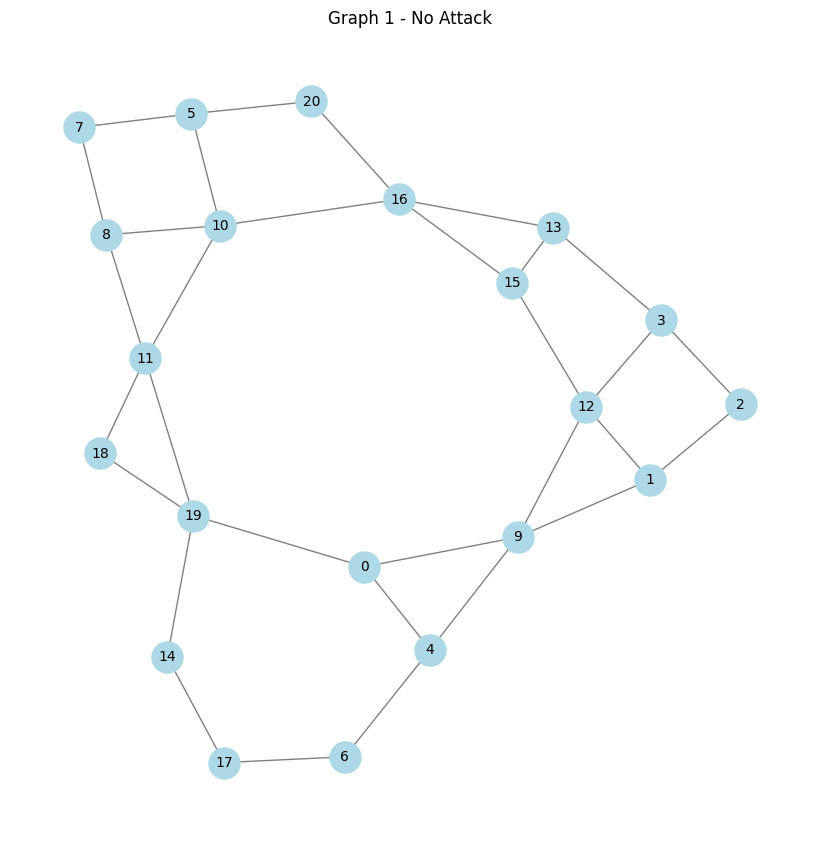

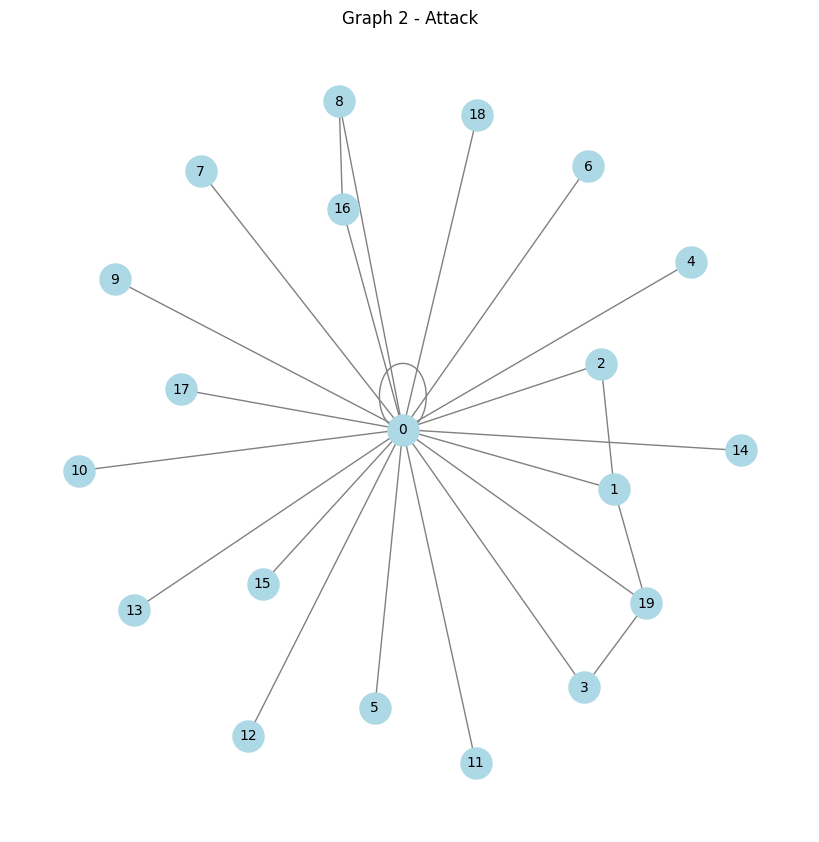

In [28]:
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import networkx as nx

# Visualize a few graphs from test_loader
def visualize_graph(data, label, node_color=None, title_prefix="Graph Visualization"):
    """
    Visualizes a PyTorch Geometric graph using NetworkX and Matplotlib.

    Args:
        data (torch_geometric.data.Data): A PyTorch Geometric Data object.
        node_color (list or None): Colors for the nodes (optional).
        title (str): Title of the plot.
    """
    # Convert PyTorch Geometric Data to NetworkX graph
    G = to_networkx(data, to_undirected=True)
    # Determine the label description
    label_description = "Attack" if label == 1 else "No Attack"

    # Set up the plot
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G)  # Use a spring layout for visualization

    # Draw the graph
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color=node_color if node_color else "lightblue",
        node_size=500,
        edge_color="gray",
        font_size=10,
        font_color="black",
    )
    plt.title(f"{title_prefix} - {label_description}")
    plt.show()

# Example: Visualize the first 3 graphs in test_loader
for i, data in enumerate(test_loader):
    if i >= 2:  # Limit to 3 graphs
        break
    # Extract the first graph from the batch
    single_graph = data[0]  # Access the first graph in the batch
    label = data.y[0].item()  # Get the label of the first graph
    visualize_graph(single_graph, label, title_prefix=f"Graph {i + 1}")

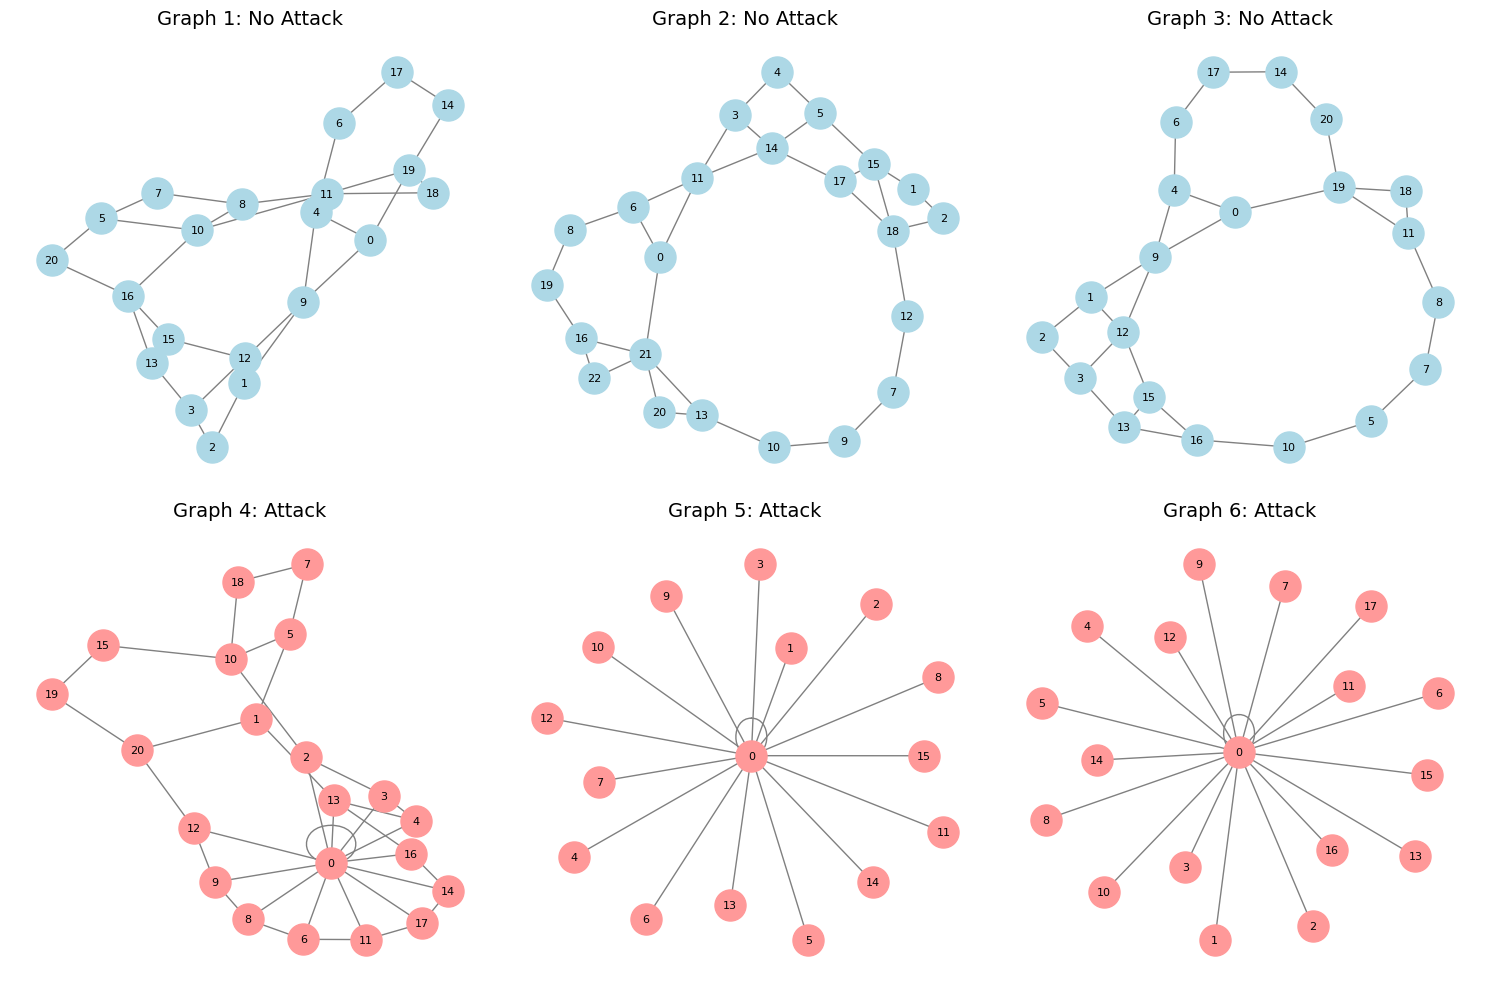

In [34]:
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import networkx as nx

def visualize_graphs_as_subplots(data_list, labels, rows=2, cols=3):
    """
    Visualizes multiple PyTorch Geometric graphs as subplots with custom node colors
    and larger text for titles.

    Args:
        data_list (list): List of PyTorch Geometric Data objects.
        labels (list): List of labels corresponding to the graphs (0 or 1).
        rows (int): Number of rows in the subplot grid.
        cols (int): Number of columns in the subplot grid.
    """
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

    for i, (data, label) in enumerate(zip(data_list, labels)):
        if i >= len(axes):  # Stop if there are more graphs than subplots
            break

        # Convert PyTorch Geometric Data to NetworkX graph
        G = to_networkx(data, to_undirected=True)
        pos = nx.spring_layout(G)  # Use a spring layout for visualization

        # Set node color based on the label
        node_color = "#ADD8E6" if label == 0 else "#FF9999"  # Light blue for "No Attack", Soft red for "Attack"

        # Determine the label description
        label_description = "Attack" if label == 1 else "No Attack"

        # Draw the graph on the current subplot
        nx.draw(
            G,
            pos,
            ax=axes[i],
            with_labels=True,
            node_color=node_color,
            node_size=500,
            edge_color="gray",
            font_size=8,
            font_color="black",
        )
        axes[i].set_title(f"Graph {i + 1}: {label_description}", fontsize=14)  # Larger title font size

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

# Example: Visualize the first 3 "No Attack" and first 3 "Attack" graphs
no_attack_graphs = []
attack_graphs = []

# Extract graphs and their labels
for i, batch in enumerate(test_loader):
    for j in range(batch.num_graphs):
        if len(no_attack_graphs) < 3 and batch.y[j].item() == 0:
            no_attack_graphs.append(batch[j])  # Add "No Attack" graph
        elif len(attack_graphs) < 3 and batch.y[j].item() == 1:
            attack_graphs.append(batch[j])  # Add "Attack" graph

        # Stop if we have enough graphs
        if len(no_attack_graphs) >= 3 and len(attack_graphs) >= 3:
            break
    if len(no_attack_graphs) >= 3 and len(attack_graphs) >= 3:
        break

# Combine the graphs and labels for visualization
data_list = no_attack_graphs + attack_graphs
labels = [0] * len(no_attack_graphs) + [1] * len(attack_graphs)

# Visualize the graphs as subplots
visualize_graphs_as_subplots(data_list, labels, rows=2, cols=3)

In [25]:
for i, data in enumerate(test_loader):
    print(data.x.shape)

torch.Size([2409, 10])
torch.Size([2581, 10])
torch.Size([2438, 10])
torch.Size([2484, 10])
torch.Size([2667, 10])
torch.Size([2649, 10])
torch.Size([2219, 10])
torch.Size([2682, 10])
torch.Size([2411, 10])
torch.Size([2339, 10])
torch.Size([2611, 10])
torch.Size([2501, 10])
torch.Size([2379, 10])
torch.Size([2550, 10])
torch.Size([2530, 10])
torch.Size([2493, 10])
torch.Size([2344, 10])
torch.Size([2640, 10])
torch.Size([2298, 10])
torch.Size([2630, 10])
torch.Size([2371, 10])
torch.Size([2670, 10])
torch.Size([2300, 10])
torch.Size([2690, 10])
torch.Size([2279, 10])
torch.Size([2706, 10])
torch.Size([2400, 10])
torch.Size([2435, 10])
torch.Size([2622, 10])
torch.Size([2540, 10])
torch.Size([2526, 10])
torch.Size([2390, 10])
torch.Size([2591, 10])
torch.Size([2613, 10])
torch.Size([2552, 10])
torch.Size([2509, 10])
torch.Size([2375, 10])
torch.Size([2608, 10])
torch.Size([2603, 10])
torch.Size([2585, 10])
torch.Size([2614, 10])
torch.Size([2506, 10])
torch.Size([2471, 10])
torch.Size(

In [4]:
# Load the test dataset using graph_creation
test_dataset = graph_creation("../datasets/can-train-and-test-v1.5/hcrl-ch", folder_type="test_")
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Processing file: ../datasets/can-train-and-test-v1.5/hcrl-ch\test_01_DoS\DoS-test.csv
Processing file: ../datasets/can-train-and-test-v1.5/hcrl-ch\test_02_fuzzing\fuzzing-test.csv
Processing file: ../datasets/can-train-and-test-v1.5/hcrl-ch\test_03_gear_spoofing\gear-test.csv
Processing file: ../datasets/can-train-and-test-v1.5/hcrl-ch\test_04_rpm_spoofing\rpm-test.csv


In [23]:
teacher_model.eval()
embeddings_list = []
with torch.no_grad():
    for data in test_loader:  # Iterate through the DataLoader
        data = data.to(device)  # Move the batch to the device
        embedding = teacher_model(data)  # Get the embeddings
        embeddings_list.append(embedding.cpu())  # Collect embeddings on the CPU

# Combine all embeddings into a single tensor
embeddings = torch.cat(embeddings_list, dim=0)  # Shape: [num_nodes, embedding_dim]

In [ ]:
teacher_model.eval()
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        graph_embedding = teacher_model(data, return_intermediate=False)
        #print(f"Graph embedding shape: {graph_embedding.shape}")

Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Size([128, 1])
Graph embedding shape: torch.Siz

KeyboardInterrupt: 

In [ ]:
teacher_model.eval()
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        intermediate_outputs = teacher_model(data, return_intermediate=True)
        for i, layer_output in enumerate(intermediate_outputs):
            # print(f"Layer {i} output shape: {layer_output.shape}")

Layer 0 output shape: torch.Size([2409, 256])
Layer 1 output shape: torch.Size([2409, 256])
Layer 2 output shape: torch.Size([2409, 256])
Layer 3 output shape: torch.Size([2409, 256])
Layer 4 output shape: torch.Size([2409, 256])
Layer 0 output shape: torch.Size([2581, 256])
Layer 1 output shape: torch.Size([2581, 256])
Layer 2 output shape: torch.Size([2581, 256])
Layer 3 output shape: torch.Size([2581, 256])
Layer 4 output shape: torch.Size([2581, 256])
Layer 0 output shape: torch.Size([2438, 256])
Layer 1 output shape: torch.Size([2438, 256])
Layer 2 output shape: torch.Size([2438, 256])
Layer 3 output shape: torch.Size([2438, 256])
Layer 4 output shape: torch.Size([2438, 256])
Layer 0 output shape: torch.Size([2484, 256])
Layer 1 output shape: torch.Size([2484, 256])
Layer 2 output shape: torch.Size([2484, 256])
Layer 3 output shape: torch.Size([2484, 256])
Layer 4 output shape: torch.Size([2484, 256])
Layer 0 output shape: torch.Size([2667, 256])
Layer 1 output shape: torch.Size([

Embeddings shape: torch.Size([2409, 256])
Labels shape: (2409,)


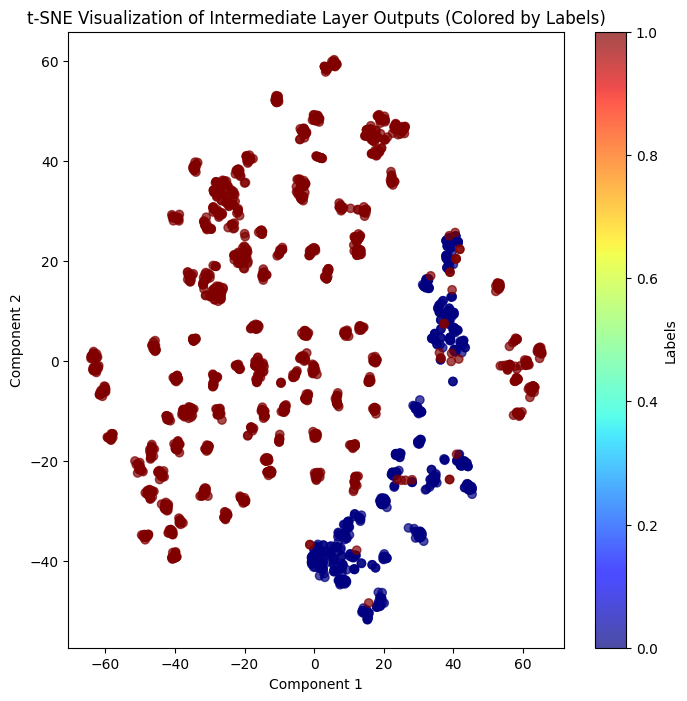

In [11]:
# Extract intermediate outputs
# Extract intermediate outputs and labels
teacher_model.eval()
intermediate_outputs_list = []
labels_list = []

max_batches = 1  # Limit the number of batches to process

with torch.no_grad():
    for i, data in enumerate(test_loader):
        if i >= max_batches:  # Stop after processing `max_batches`
            break
        data = data.to(device)
        intermediate_outputs = teacher_model(data, return_intermediate=True)  # Get intermediate outputs
        intermediate_outputs_list.append(intermediate_outputs[-1].cpu())  # Use the last layer's output
        labels_list.append(data.y[data.batch].cpu())  # Map graph labels to nodes using `data.batch`

# Combine outputs and labels into single tensors
embeddings = torch.cat(intermediate_outputs_list, dim=0)  # Shape: [num_nodes, embedding_dim]
labels = torch.cat(labels_list, dim=0).numpy()  # Shape: [num_nodes]
print(f"Embeddings shape: {embeddings.shape}")
print(f"Labels shape: {labels.shape}")
# Apply t-SNE
z = TSNE(n_components=2).fit_transform(embeddings.numpy())  # Reduce to 2D

# Plot with labels
plt.figure(figsize=(8, 8))
plt.scatter(z[:, 0], z[:, 1], c=labels, cmap="jet", alpha=0.7)
plt.title("t-SNE Visualization of Intermediate Layer Outputs (Colored by Labels)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Labels")
plt.show()

c:\Users\rober\miniconda3\envs\graph\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\rober\miniconda3\envs\graph\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


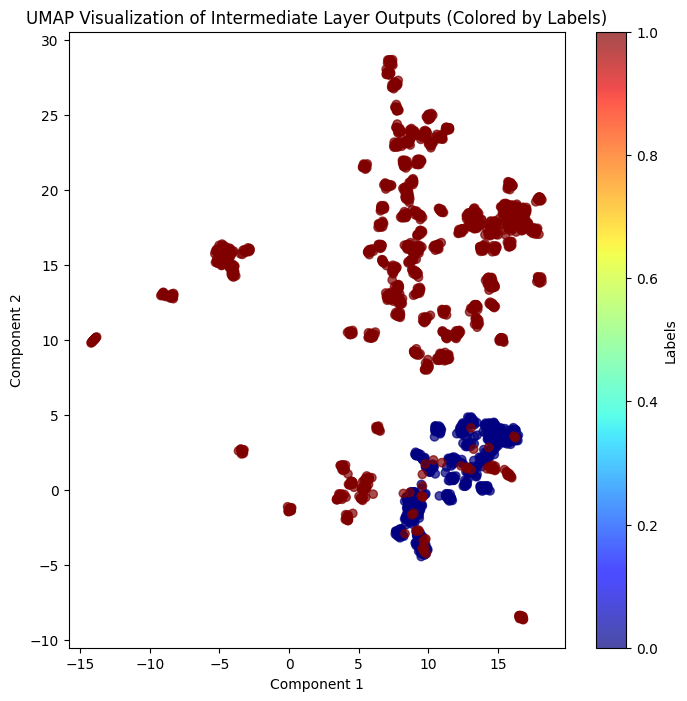

In [13]:
import umap
# Extract intermediate outputs and labels
teacher_model.eval()
intermediate_outputs_list = []
labels_list = []

max_batches = 1  # Limit the number of batches to process

with torch.no_grad():
    for i, data in enumerate(test_loader):
        if i >= max_batches:  # Stop after processing `max_batches`
            break
        data = data.to(device)
        intermediate_outputs = teacher_model(data, return_intermediate=True)  # Get intermediate outputs
        intermediate_outputs_list.append(intermediate_outputs[-1].cpu())  # Use the last layer's output

        # Expand graph-level labels to match the number of nodes
        labels_list.append(data.y[data.batch].cpu())  # Map graph labels to nodes using `data.batch`

# Combine outputs and labels into single tensors
embeddings = torch.cat(intermediate_outputs_list, dim=0)  # Shape: [num_nodes, embedding_dim]
labels = torch.cat(labels_list, dim=0).numpy()  # Shape: [num_nodes]

# Apply UMAP
# reducer = umap.UMAP(n_components=2, random_state=42) # default settings

# reducer = umap.UMAP(n_neighbors=5, min_dist=0.1, random_state=42) # local structure
reducer = umap.UMAP(n_neighbors=50, min_dist=0.5, random_state=42) # global structure
z = reducer.fit_transform(embeddings.numpy())  # Reduce to 2D

# Plot with labels
plt.figure(figsize=(8, 8))
plt.scatter(z[:, 0], z[:, 1], c=labels, cmap="jet", alpha=0.7)
plt.title("UMAP Visualization of Intermediate Layer Outputs (Colored by Labels)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Labels")
plt.show()

c:\Users\rober\miniconda3\envs\graph\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\rober\miniconda3\envs\graph\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\rober\miniconda3\envs\graph\lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


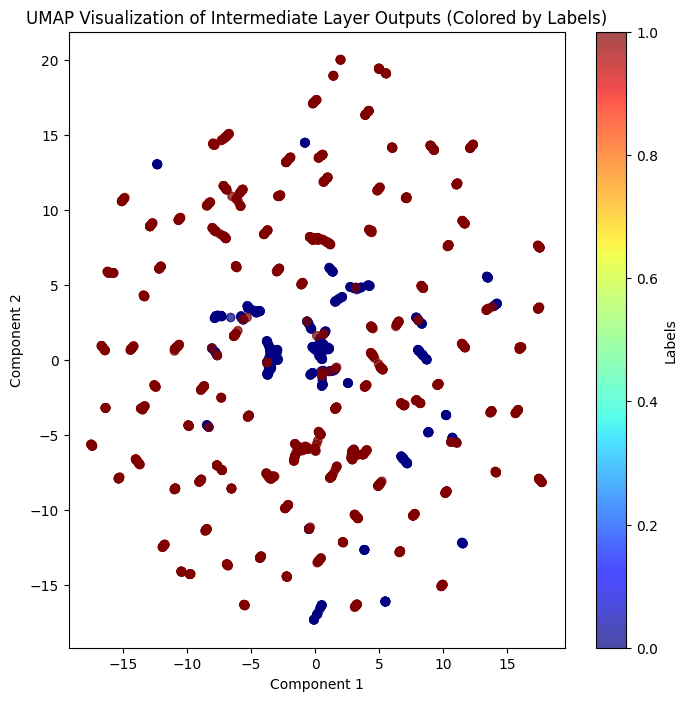

In [14]:
import umap
# Extract intermediate outputs and labels
teacher_model.eval()
intermediate_outputs_list = []
labels_list = []

max_batches = 1  # Limit the number of batches to process

with torch.no_grad():
    for i, data in enumerate(test_loader):
        if i >= max_batches:  # Stop after processing `max_batches`
            break
        data = data.to(device)
        intermediate_outputs = teacher_model(data, return_intermediate=True)  # Get intermediate outputs
        intermediate_outputs_list.append(intermediate_outputs[-1].cpu())  # Use the last layer's output

        # Expand graph-level labels to match the number of nodes
        labels_list.append(data.y[data.batch].cpu())  # Map graph labels to nodes using `data.batch`

# Combine outputs and labels into single tensors
embeddings = torch.cat(intermediate_outputs_list, dim=0)  # Shape: [num_nodes, embedding_dim]
labels = torch.cat(labels_list, dim=0).numpy()  # Shape: [num_nodes]

# Apply UMAP
# reducer = umap.UMAP(n_components=2, random_state=42) # default settings

reducer = umap.UMAP(n_neighbors=5, min_dist=0.1, random_state=42) # local structure
# reducer = umap.UMAP(n_neighbors=50, min_dist=0.5, random_state=42) # global structure
z = reducer.fit_transform(embeddings.numpy())  # Reduce to 2D

# Plot with labels
plt.figure(figsize=(8, 8))
plt.scatter(z[:, 0], z[:, 1], c=labels, cmap="jet", alpha=0.7)
plt.title("UMAP Visualization of Intermediate Layer Outputs (Colored by Labels)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Labels")
plt.show()